# Klasifikasi menggunakan PySpark

In [1]:
# Awal inisiasi penggunaan PySpark
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Classification").getOrCreate()
spark

In [2]:
# Menggunakan beberapa library PySpark yang akan digunakan
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.classification import *
from pyspark.ml.evaluation import *
from pyspark.sql.functions import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
# Menggunakan library Matplot untuk visualisasi data nantinya
import matplotlib.pyplot as plt
import numpy as np
from numpy import polyfit

## Membuka dataset
### Dataset ini merupakan data mobil Toyota
### Sumber dataset :
#### https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes?select=toyota.csv

In [4]:
path = "../Datasets/"

df = spark.read.csv("/Users/humam/Documents/Kuliah/Big Data/Dataset/toyota.csv", inferSchema=True, header=True)
# Menampilkan tipe data kolom dari dataset
df.printSchema()

root
 |-- model: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- transmission: string (nullable = true)
 |-- mileage: integer (nullable = true)
 |-- fuelType: string (nullable = true)
 |-- tax: integer (nullable = true)
 |-- mpg: double (nullable = true)
 |-- engineSize: double (nullable = true)



In [5]:
df.limit(20).toPandas()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0
5,GT86,2017,15998,Manual,26919,Petrol,260,36.2,2.0
6,GT86,2017,18522,Manual,10456,Petrol,145,36.2,2.0
7,GT86,2017,18995,Manual,12340,Petrol,145,36.2,2.0
8,GT86,2020,27998,Manual,516,Petrol,150,33.2,2.0
9,GT86,2016,13990,Manual,37999,Petrol,265,36.2,2.0


## Memilih kolom variabel dependen dan memeriksa apakah dataset seimbang antara beberapa kelas di variabel dependen 

In [5]:
# Data dependen harus memiliki nilai yang seimbang
# Dataset tidak seimbang jika hanya ada 10 kasus untuk salah satu kelas atau kurang dari 1% dari keseluruhan data
# Disini kita menggunakan kolom fuelType dikarenakan kolom ini merupakan kolom variabel dependen yang sudah sesuai
df.groupBy("fuelType").agg(count(df["fuelType"]).alias("Jumlah Kelas")).show()

+--------+------------+
|fuelType|Jumlah Kelas|
+--------+------------+
|  Diesel|         503|
|   Other|         105|
|  Hybrid|        2043|
|  Petrol|        4087|
+--------+------------+



## Melakukan *formatting* sebagai model pada dataset

In [6]:
input_columns = df.columns # Mengumpulkan daftar kolom dataset
input_columns = input_columns[0:-5] # Mengeliminasi kolom nomor yang tidak digunakan

# Disini kita menggunakan kolom fuelType sebagai variabel dependen-nya
dependent_var = "fuelType" # Berdasarkan nama variabel kolom

In [7]:
# Re-index variabel dependen dimulai dari 0

# Mengganti nama variable dependen menjadi tipe data String
renamed = df.withColumn('label_string', df[dependent_var].cast(StringType()))

# Mengubah nama kolom menjadi label dan mengubah string menjadi numerik dimulai dari 0
indexer = StringIndexer(inputCol="label_string", outputCol="label")
# Menggunakan fit method sebagai perhitungan label output kolom
# Selanjutnya akan ditransform ke index yang telah diubah
indexed = indexer.fit(renamed).transform(renamed)

### Menkonversi tipe data string menjadi numerik

In [8]:
# Membuat list untuk kolom numerik dan kolom string
numeric_inputs = []
string_inputs = []
for column in input_columns:
    if str(indexed.schema[column].dataType) == "StringType":
        # Menyiapkan fungsi StringIndexer, dan mengubah nama kolom baru
        indexer = StringIndexer(inputCol=column, outputCol=column+"_numerik")
        # Memanggil fit method dan transform method untuk mengubah dataframe
        indexed = indexer.fit(indexed).transform(indexed)
        # Mengganti nama kolom menjadi kolom baru sehingga dapat dibedakan dari aslinya
        new_col_name = column+"_numerik"
        # Menambah list kolom baru
        string_inputs.append(new_col_name)
    
    else:
        # Menambahkan daftar kolom numerik
        numeric_inputs.append(column)

In [9]:
print(string_inputs)
print(numeric_inputs)

['model_numerik', 'transmission_numerik']
['year', 'price']


In [10]:
print(indexed.printSchema())

root
 |-- model: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- transmission: string (nullable = true)
 |-- mileage: integer (nullable = true)
 |-- fuelType: string (nullable = true)
 |-- tax: integer (nullable = true)
 |-- mpg: double (nullable = true)
 |-- engineSize: double (nullable = true)
 |-- label_string: string (nullable = true)
 |-- label: double (nullable = false)
 |-- model_numerik: double (nullable = false)
 |-- transmission_numerik: double (nullable = false)

None


In [11]:
indexed.limit(20).toPandas()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,label_string,label,model_numerik,transmission_numerik
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0,Petrol,0.0,10.0,0.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0,Petrol,0.0,10.0,0.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0,Petrol,0.0,10.0,0.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0,Petrol,0.0,10.0,0.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0,Petrol,0.0,10.0,0.0
5,GT86,2017,15998,Manual,26919,Petrol,260,36.2,2.0,Petrol,0.0,10.0,0.0
6,GT86,2017,18522,Manual,10456,Petrol,145,36.2,2.0,Petrol,0.0,10.0,0.0
7,GT86,2017,18995,Manual,12340,Petrol,145,36.2,2.0,Petrol,0.0,10.0,0.0
8,GT86,2020,27998,Manual,516,Petrol,150,33.2,2.0,Petrol,0.0,10.0,0.0
9,GT86,2016,13990,Manual,37999,Petrol,265,36.2,2.0,Petrol,0.0,10.0,0.0


### Memeriksa apakah ada nilai negatif pada dataset

In [12]:
# Calculate the mins for all columns in the dataset
minimums = df.select([min(c).alias(c) for c in indexed.columns if c in numeric_inputs])
# Create an array for all mins and select only the input cols
min_array = minimums.select(array(numeric_inputs).alias("mins"))
# Collect the global minimum as Python object
df_minimum = min_array.select(array_min(min_array.mins)).collect()
# get the global minimum
df_minimum = df_minimum[0][0]

# Memeriksa data yang bernilai negatif
if df_minimum < 0:
    print("WARNING : Klasifikasi Naive Bayes tidak dapat memproses jika memiliki data yang bernilai negatif di dataframe")
else:
    print("Tidak ada nilai negatif pada dataframe")

Tidak ada nilai negatif pada dataframe


### *Scaling features* ke bentuk vektor 

In [25]:
# Vektorisasi dataframe
# Dikarenakan fungsi ini membutuhkan vektor
features_list = numeric_inputs + string_inputs # Menentukan input yang diinginkan untuk dimasukkan ke dalam features

# Membuat vektor assembler
assembler = VectorAssembler(inputCols=features_list, outputCol='features')
# Panggil vektor assembler untuk transform ke dataframe
output = assembler.transform(indexed).select('features', 'label')

In [26]:
output.show(20, False)

+-------------------------+-----+
|features                 |label|
+-------------------------+-----+
|[2016.0,16000.0,10.0,0.0]|0.0  |
|[2017.0,15995.0,10.0,0.0]|0.0  |
|[2015.0,13998.0,10.0,0.0]|0.0  |
|[2017.0,18998.0,10.0,0.0]|0.0  |
|[2017.0,17498.0,10.0,0.0]|0.0  |
|[2017.0,15998.0,10.0,0.0]|0.0  |
|[2017.0,18522.0,10.0,0.0]|0.0  |
|[2017.0,18995.0,10.0,0.0]|0.0  |
|[2020.0,27998.0,10.0,0.0]|0.0  |
|[2016.0,13990.0,10.0,0.0]|0.0  |
|[2013.0,10495.0,10.0,0.0]|0.0  |
|[2017.0,17990.0,10.0,0.0]|0.0  |
|[2017.0,16995.0,10.0,0.0]|0.0  |
|[2019.0,23995.0,10.0,0.0]|0.0  |
|[2018.0,18498.0,10.0,0.0]|0.0  |
|[2019.0,23980.0,10.0,0.0]|0.0  |
|[2017.0,17995.0,10.0,0.0]|0.0  |
|[2014.0,12998.0,10.0,0.0]|0.0  |
|[2019.0,23495.0,10.0,1.0]|0.0  |
|[2019.0,25780.0,10.0,0.0]|0.0  |
+-------------------------+-----+
only showing top 20 rows



### Membuat nilai skalar

In [27]:
# Membuat min,max nilai skalar
# Melakukan penskalaan pada dataframe dengan nilai min = 0, max = 1
scalar = MinMaxScaler(inputCol="features", outputCol="scaledFeatures", min=0, max=1)
print("Features diskalakan dengan range : [%f, %f]" % (scalar.getMin(), scalar.getMax()))

# Menghitung hasil statistik dan menghasilkan modelnya
scalerModel = scalar.fit(output)
# Transform setiap fitur berdasarkan nilai min dan max
scaled_data = scalerModel.transform(output)
#scaled_data.show(5)
# selecting only the label and new scaled features from the scaled_data dataframe
final_data = scaled_data.select('scaledFeatures', 'label')

# Rename the scaledFeature to its default name
final_data = final_data.withColumnRenamed("scaledFeatures", "features")
final_data.show()

Features diskalakan dengan range : [0.000000, 1.000000]
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.81818181818181...|  0.0|
|[0.86363636363636...|  0.0|
|[0.77272727272727...|  0.0|
|[0.86363636363636...|  0.0|
|[0.86363636363636...|  0.0|
|[0.86363636363636...|  0.0|
|[0.86363636363636...|  0.0|
|[0.86363636363636...|  0.0|
|[1.0,0.4590075238...|  0.0|
|[0.81818181818181...|  0.0|
|[0.68181818181818...|  0.0|
|[0.86363636363636...|  0.0|
|[0.86363636363636...|  0.0|
|[0.95454545454545...|  0.0|
|[0.90909090909090...|  0.0|
|[0.95454545454545...|  0.0|
|[0.86363636363636...|  0.0|
|[0.72727272727272...|  0.0|
|[0.95454545454545...|  0.0|
|[0.95454545454545...|  0.0|
+--------------------+-----+
only showing top 20 rows



## Melakukan *training* dan *test* dataset

In [28]:
# Memisahkan data random dengan ratio 70:30
train, test = final_data.randomSplit([0.7, 0.3])

In [29]:
print("Training dataset : ",train.count())
print("Test dataset : ", test.count())

Training dataset :  4736
Test dataset :  2002


## Model *Logistic Regression*
### Melakukan evaluasi

In [30]:
# Memuat objek yang dapat dievaluasi
# Evaluasi di bawah digunakan ketika memiliki klasifikasi biner sebagai bentuk prediksi
Binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction')
# Evaluasi di bawah digunakan untuk klasifikasi biner dan bisa juga untuk klasifikasi multiclass
# sebagai bentuk akurasi
Multiclass_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')

In [31]:
# Menjalankan model Logistic Regression
classifier = LogisticRegression()
# Fitting model dengan training data-nya
fitModel = classifier.fit(train)

# Mengeluarkan tabel data prediksi dan label
PredictionAndLabel = fitModel.transform(test)
# Menampilkan 20 data
PredictionAndLabel.show(20)

# Evaluation method untuk klasifikasi biner ke dalam bentuk AUC
predict = Binary_evaluator.evaluate(PredictionAndLabel)
print("AUC :",predict)

# Evaluation method untuk klasifikasi multiclass ke dalam bentuk akurasi
accuracy = (Multiclass_evaluator.evaluate(PredictionAndLabel))*100
print("Akurasi : {0:.2f}".format(accuracy),"%")

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.13636363636363...|  0.0|[-0.9214987457343...|[0.04268059546192...|       2.0|
|[0.18181818181818...|  0.0|[-0.7026494249096...|[0.03712438609006...|       2.0|
|[0.18181818181818...|  0.0|[-1.7021052306445...|[0.00635712248659...|       1.0|
|[0.22727272727272...|  0.0|[0.19943097276743...|[0.03151140659864...|       2.0|
|[0.27272727272727...|  0.0|[0.68644916599310...|[0.06841678106045...|       2.0|
|[0.27272727272727...|  0.0|[0.43197537925224...|[0.04818688233786...|       2.0|
|[0.27272727272727...|  0.0|[-0.8154030431929...|[0.02467758106417...|       1.0|
|[0.31818181818181...|  0.0|[0.01034256747236...|[0.11601582522535...|       2.0|
|[0.31818181818181...|  2.0|[-0.1495266207910...|[0.00237621351583...|       2.0|
|[0.363636363636

### Melihat nilai koefisien dan intersep

In [20]:
# Menampilkan nilai koefisien dan intersep
print("Coefficients : \n" + str(fitModel.coefficientMatrix))
print("Intercept : " + str(fitModel.interceptVector))

Coefficients : 
DenseMatrix([[  7.89969753, -16.2963185 ],
             [ -3.60638809,   7.855277  ],
             [ -7.23586314,   8.90321546],
             [  2.9425537 ,  -0.46217396]])
Intercept : [-1.949745335473671,2.4104671179581674,3.748359355501344,-4.209081137985841]


In [21]:
# Mewakili koefisien dengan prediktor
# Membuat dataframe untuk lebih melihat koefisien dengan prediktor yang sesuai
# Mengkonversi koefisien dari array menjadi list
coeff_array = fitModel.coefficientMatrix.toArray()
coeff_score = [] 

# Memeriksa setiap koefisien dan menambahkannya ke dalam daftar
for x in coeff_array[0]:
    coeff_score.append(float(x))

# Membuat dataframe-nya
result = spark.createDataFrame(zip(features_list,coeff_score), schema=['feature', 'coefficient'])
result.show(20, False)

+-------+-------------------+
|feature|coefficient        |
+-------+-------------------+
|year   |7.899697530928483  |
|price  |-16.296318504821823|
+-------+-------------------+



### Menambah metode *Cross Validator*

In [22]:
classifier = LogisticRegression()

# Mengatur parameter grid untuk cross validator
paramGrid = (ParamGridBuilder().addGrid(classifier.maxIter, [10, 15, 20]).build())
paramGrid

# Mengatur Cross Validator 
crossval = CrossValidator(estimator = classifier,
                         estimatorParamMaps = paramGrid,
                         evaluator = Multiclass_evaluator,
                         numFolds = 5)

# Fit model
fitModel1 = crossval.fit(train)
BestModel = fitModel1.bestModel
print("Intercept : " + str(BestModel.interceptVector))
print("\nCoefficients : \n" + str(BestModel.coefficientMatrix))
print(BestModel)

# Fitmodel secara otomatis menggunakan Bestmodel maka bisa digunakan langsung pada test data
predictions = fitModel1.transform(test)
# Memeriksa akurasi model
accuracy = (Multiclass_evaluator.evaluate(predictions))*100
print('\nAkurasi :', accuracy)

Intercept : [-1.7993944256563332,2.5279558316221,1.4072696680258465,-2.1358310739916133]

Coefficients : 
DenseMatrix([[  7.31455664, -15.16067873],
             [ -3.54086774,   6.59552621],
             [ -4.1088718 ,   7.02177266],
             [  0.33518289,   1.54337986]])
LogisticRegressionModel: uid=LogisticRegression_38562472b440, numClasses=4, numFeatures=2

Akurasi : 76.60110943015633


## Visualisasi data
### Perbandingan data harga dengan data lainnya pada dataframe

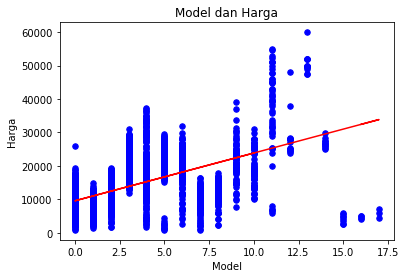

0 = Yaris 
1 = Aygo 
2 = Auris 
3 = C-HR 
4 = RAV4 
5 = Corolla 
6 = Prius 
7 = Avensis 
8 = Verso 
9 = Hilux 

10 = GT86 
11 = Land Cruiser 
12 = PROACE VERSO 
13 = Supra 
14 = Camry 
15 = IQ 
16 = Urban Cruiser 
17 = Verso-S


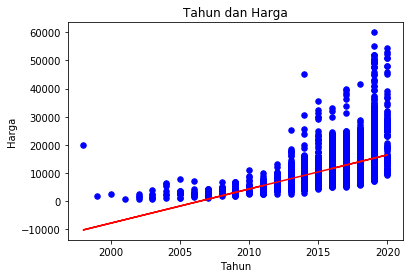

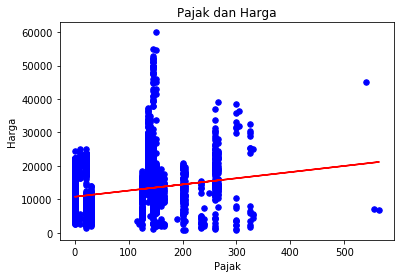

In [23]:
# Menampilkan Regression Line Model dan Harga pada dataset
x1 = indexed.toPandas()['model_numerik'].values.tolist()
y1 = indexed.toPandas()['price'].values.tolist()
plt.scatter(x1, y1, color='blue', s=30)

# Labelling
plt.xlabel('Model')
plt.ylabel('Harga')
plt.title('Model dan Harga')
p1 = polyfit(x1, y1, 1)
plt.plot(x1, np.polyval(p1,x1), 'red' )
plt.show()

# Penjelasan model karena menggunakan dataframe yang sudah di indekskan
# Dari tipe data string menjadi bentuk numerik
print('0 = Yaris \n1 = Aygo \n2 = Auris \n3 = C-HR \n4 = RAV4 \n5 = Corolla \n6 = Prius \n7 = Avensis \n8 = Verso \n9 = Hilux \n')
print('10 = GT86 \n11 = Land Cruiser \n12 = PROACE VERSO \n13 = Supra \n14 = Camry \n15 = IQ \n16 = Urban Cruiser \n17 = Verso-S')

x1 = df.toPandas()['year'].values.tolist()
y1 = df.toPandas()['price'].values.tolist()
plt.scatter(x1, y1, color='blue', s=30)

# Labelling
plt.xlabel('Tahun')
plt.ylabel('Harga')
plt.title('Tahun dan Harga')
p1 = polyfit(x1, y1, 1)
plt.plot(x1, np.polyval(p1,x1), 'red' )
plt.show()

# Menampilkan Regression Line Pajak dan Harga pada dataset
x1 = df.toPandas()['tax'].values.tolist()
y1 = df.toPandas()['price'].values.tolist()
plt.scatter(x1, y1, color='blue', s=30)

# labelling
plt.xlabel('Pajak')
plt.ylabel('Harga')
plt.title('Pajak dan Harga')
p1 = polyfit(x1, y1, 1)
plt.plot(x1, np.polyval(p1,x1), 'red' )
plt.show()
